In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [4]:
aux = pd.read_csv('auxdiario_dia_junio.csv',header = None)
aux.columns=['local','mac','ventanas']
aux.head(5)

,local,mac,ventanas
0,1101049,00:00:06:AF:43:11,19
1,1101049,00:02:C3:DF:7D:CA,7
2,1101049,00:03:AA:FD:56:45,6
3,1101049,00:08:22:04:29:44,7
4,1101049,00:08:22:0A:5E:FC,17


In [3]:
aux.describe()

,local,ventanas
count,3.399920e+05,339992.000000
mean,5.057247e+06,71.641918
std,1.143743e+07,234.181151
min,1.101049e+06,1.000000
25%,1.108103e+06,2.000000
50%,1.201003e+06,4.000000
75%,1.210103e+07,29.000000
max,1.301077e+08,8285.000000


# Filtrado de usuarios por cantidad de uso

Se filtran los datos que no son de interés, esto es, nos quedamos con los dispositivos que estuvieron al menos 1 hora a lo largo del mes, y los que estuvieron a lo sumo 15 hs 22 dias en el mes.

In [5]:
aux = aux[aux.ventanas.between(13,22*15*12)]
aux.describe()

,local,ventanas
count,1.162380e+05,116238.000000
mean,5.846681e+06,192.508362
std,1.042101e+07,268.571893
min,1.101049e+06,13.000000
25%,1.113120e+06,27.000000
50%,1.204409e+06,76.000000
75%,1.211111e+07,267.000000
max,1.301077e+08,3957.000000


In [6]:
x = aux.ventanas

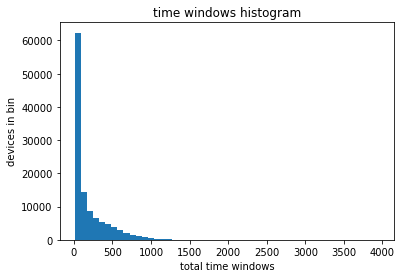

In [7]:
plt.xlabel('total time windows')
plt.ylabel('devices in bin')
plt.title('time windows histogram')
plt.hist(x,bins=50)

plt.show()

#### Chequeo la existencia de outliers al realizar transformación logarítmica

In [8]:
x = np.log(aux.ventanas)

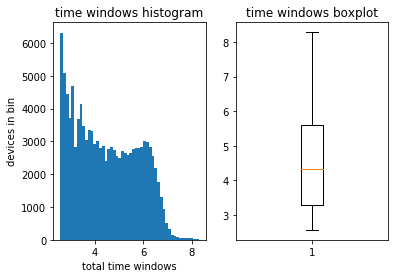

In [9]:
plt.subplot(1, 2, 1)
plt.xlabel('total time windows')
plt.ylabel('devices in bin')
plt.title('time windows histogram')
plt.hist(x,bins=50)

plt.subplot(1, 2, 2)
plt.title('time windows boxplot')
plt.boxplot(x)

plt.show()

[3.295837 2.564949]
[5.587249 8.283241]


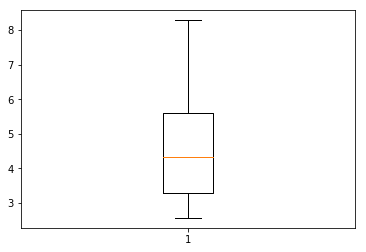

In [10]:
B=plt.boxplot(x)
for item in B['whiskers']:
    print(np.round(item.get_ydata(),6))

In [11]:
display(x[x>8.283241])
display(x[x<2.564949])

238469    8.283241
Name: ventanas, dtype: float64

Series([], Name: ventanas, dtype: float64)

#### Chequeo la existencia de outliers al realizar transformación box-cox

In [12]:
x, _ = stats.boxcox(aux.ventanas)

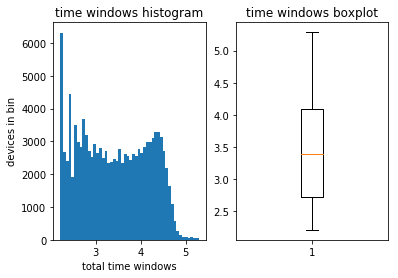

In [13]:
plt.subplot(1, 2, 1)
plt.xlabel('total time windows')
plt.ylabel('devices in bin')
plt.title('time windows histogram')
plt.hist(x,bins=50)

plt.subplot(1, 2, 2)
plt.title('time windows boxplot')
plt.boxplot(x)

plt.show()

[2.73061798 2.21320761]
[4.09157797 5.28609964]


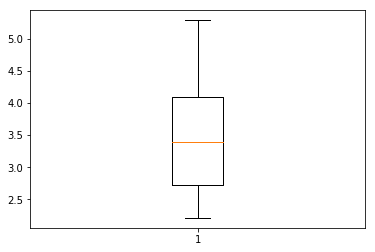

In [14]:
B=plt.boxplot(x)
for item in B['whiskers']:
    print(item.get_ydata())

In [15]:
display(x[x>5.2861 ])
display(x[x<2.21320761])

array([], dtype=float64)

array([], dtype=float64)

#### Observaciones de outliers

Confirmamos que al realizar una transformación logarítmica no se ven outliers y al realizar una transformación box cox de los datos tampoco.

#### Aplico filtro al dataset original

In [16]:
aux['concat'] = aux['local'].astype('str')+'concat'+aux['mac']
aux.head(2)

,local,mac,ventanas,concat
0,1101049,00:00:06:AF:43:11,19,1101049concat00:00:06:AF:43:11
4,1101049,00:08:22:0A:5E:FC,17,1101049concat00:08:22:0A:5E:FC


In [17]:
datos = pd.read_csv('auxdiario_fecha_junio.csv', names = ['local','mac','app','fecha','ventanas'])
datos['concat'] = datos['local'].astype('str')+'concat'+datos['mac']

In [18]:
#genero lista de macs aprobadas para su inclusión en el estudio
macs_aprobadas = aux.concat.tolist()
aux = None
#guardo un dataset que contenga solamente las macs aprobadas
datos[datos['concat'].isin(macs_aprobadas)][['local','mac','app','fecha','ventanas']].to_csv('junio_filtrado.csv',index=False)

# Cuales son las apps mas importantes?
Las aplicaciones a utilizar salen del dataset: para ver las apps mas relevantes se toman las observaciones de cada equipo por cada aplicacion y simplemente se suman dichas observaciones para cada aplicacion, de esta forma nos quedamos con la cantidad total de veces en las que hubo un registro de uso (individual) de dicha app.
Se considero un umbral mínimo 2000 registros de uso individual en el mes para tomar en cuenta la aplicacion.

In [19]:
datos = pd.read_csv('junio_filtrado.csv')
datos.head()

,local,mac,app,fecha,ventanas
0,1101049,00:00:06:AF:43:11,DNS,2018-06-08,4
1,1101049,00:00:06:AF:43:11,DNS,2018-06-20,2
2,1101049,00:00:06:AF:43:11,DNS,2018-06-21,2
3,1101049,00:00:06:AF:43:11,DNS,2018-06-22,4
4,1101049,00:00:06:AF:43:11,Facebook,2018-06-08,5


In [20]:
apps_importantes = datos.groupby(['app'])[['ventanas']].sum().reset_index().sort_values('ventanas',ascending=False)
display(apps_importantes.head())

categorizacion = ['Navegacion','drop','Navegacion','Navegacion','Red_social','Comunicacion','Navegacion',
                  'Red_social','drop','drop','Navegacion','drop','Comunicacion','drop',
                  'Navegacion_Ceibal','Multimedia_videos','drop','drop','Apple','Marketplace','drop','Microsoft',
                  'Red_social','drop','correo','almacenamiento','Comunicacion','drop','Navegacion','Multimedia_musica',
                  'Multimedia_videos','drop','drop','drop','drop','herramienta_educativa','Navegacion','drop',
                  'Red_social','Multimedia_musica','drop','almacenamiento','Navegacion_Ceibal','drop',
                  'herramienta_educativa','almacenamiento','Navegacion','Multimedia_videos','correo',
                  'Educacion_Ceibal','drop','red','Navegacion_Ceibal','GoogleMaps','Red_social','Educacion_Ceibal',
                  'drop','drop','ibirapita_Ceibal','Multimedia_videos','drop','drop','Educacion_Ceibal',
                  'Comunicacion','drop','drop','Marketplace','herramienta_educativa','Educacion_Ceibal','Multimedia_musica',
                  'Comunicacion','drop','Navegacion_Ceibal','Navegacion_Ceibal','drop','drop','drop','drop']
drop_list = ['Microsoft','Apple','drop','red']

,app,ventanas
27,Google,18480573
132,Unknown,17544626
15,DNS,14351017
104,SSL,14014874
22,Facebook,11212664


##### apps relevantes cuya categorización no fue evidente
- 'ingreso_Ceibal':lo puse como Educacion_Ceibal porque asumo que es lo que hay que hacer para loguearse en las plataformas de aprendizaje
- 'ibirapita_Ceibal':lo dejé como categoría separada
- 'portal_ceibal':lo pasé a Navegacion_ceibal
- 'Schoology-Ceibal': lo pasé a Navegacion_ceibal
- 'miespacio_Ceibal':  lo pasé a Navegacion_ceibal

##### apps relevantes eliminadas:
- 'PCA Ceibal', al igual que todas las etiquetas pertenecientes a protocolos de red (o a cualquier cosa cuya finalidad sea permitir la comunicación entre los dispositivos y la red) fue categorizado como 'drop' y desestimado.
- 'Microsoft', al igual que las otras etiquetas que están vinculadas a la actualizacion de apps, software, etc fueron eliminadas.
- 'Apple', fue eliminado bajo la sospecha de ser la tienda de apple o aplicaciones internas de apple. En caso de estar indicando cualquier aplicación de apple, tampoco nos serviría pues no es lo suficientemente específico.

In [21]:
importantes = apps_importantes.head(78)
importantes['Categorizacion'] = categorizacion
importantes = importantes[importantes.Categorizacion.isin(drop_list)==False][['app','Categorizacion']].set_index('app')

mapper_caracteristicas = importantes.to_dict()
print('Nos quedamos con',len(importantes),'aps, de las cuales',importantes.Categorizacion.nunique(),'son etiquetas unicas')
display(importantes.sort_values('Categorizacion',inplace=False))

print()
print()
print('Etiquetas de aplicaciones:')
print(importantes.Categorizacion.unique())



Nos quedamos con 46 aps, de las cuales 13 son etiquetas unicas


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Categorizacion
app,
Viber,Comunicacion
WhatsApp,Comunicacion
Telegram,Comunicacion
Skype,Comunicacion
QQ,Comunicacion
aulas_Ceibal,Educacion_Ceibal
bibliotecadigital_Ceibal,Educacion_Ceibal
Pam_Ceibal,Educacion_Ceibal
ingreso_Ceibal,Educacion_Ceibal




Etiquetas de aplicaciones:
['Navegacion' 'Red_social' 'Comunicacion' 'Navegacion_Ceibal'
 'Multimedia_videos' 'Marketplace' 'correo' 'almacenamiento'
 'Multimedia_musica' 'herramienta_educativa' 'Educacion_Ceibal'
 'GoogleMaps' 'ibirapita_Ceibal']


In [22]:
datos['etiquetas'] = datos.app.map(mapper_caracteristicas['Categorizacion'])
datos.dropna(inplace=True)

##### verifico cantidad de usuarios en las etiquetas

In [23]:
usuarios_por_app = datos.groupby('etiquetas')['mac'].nunique()
display(usuarios_por_app[usuarios_por_app<300])
datos = datos[datos.etiquetas!='ibirapita_Ceibal']

etiquetas
ibirapita_Ceibal    242
Name: mac, dtype: int64

In [24]:
datos.to_csv('junio_filtrado_apps_importantes.csv')
datos['app'] = datos['etiquetas']
datos = datos[['mac','app','ventanas','fecha']]
datos.head()

,mac,app,ventanas,fecha
0,00:00:06:AF:43:11,Navegacion,4,2018-06-08
1,00:00:06:AF:43:11,Navegacion,2,2018-06-20
2,00:00:06:AF:43:11,Navegacion,2,2018-06-21
3,00:00:06:AF:43:11,Navegacion,4,2018-06-22
4,00:00:06:AF:43:11,Red_social,5,2018-06-08


# Extraccion de caracteristicas

##### i) Cantidad total de observaciones por aplicacion.

Para esto agrupamos a nivel dispositivo y aplicación, y contamos la cantidad de ventanas donde se observó cada aplicación para cada individuo. Este subgrupo implica que habrá una característica por aplicación (por ejemplo, cantidad de observaciones del individuo en Facebook).


In [25]:
uso_total_apps = datos[['mac','app','ventanas']].groupby(['mac','app'])[['ventanas']].sum().reset_index()
uso_total_apps.head()

,mac,app,ventanas
0,00:00:00:3F:2E:34,Multimedia_videos,81
1,00:00:00:3F:2E:34,Navegacion,563
2,00:00:00:46:95:B4,Navegacion,878
3,00:00:00:5C:64:DE,Multimedia_videos,4
4,00:00:00:5C:64:DE,Navegacion,69


##### ii) Media diaria de observaciones por aplicacion.
Para esto agrupamos a nivel dispositivo y aplicación, y contamos la cantidad de ventanas donde se observó cada aplicación para cada individuo. Este subgrupo implica que habrá una característica por aplicación (por ejemplo, cantidad de observaciones del individuo en Facebook).

In [26]:
mediana_uso_diario_apps = datos[['mac','app','ventanas']].groupby(['mac','app'])[['ventanas']].median().reset_index()
mediana_uso_diario_apps.head()

,mac,app,ventanas
0,00:00:00:3F:2E:34,Multimedia_videos,5.0
1,00:00:00:3F:2E:34,Navegacion,5.0
2,00:00:00:46:95:B4,Navegacion,6.0
3,00:00:00:5C:64:DE,Multimedia_videos,1.0
4,00:00:00:5C:64:DE,Navegacion,1.0


##### iii) Cantidad de dias por aplicacion. 
Estás características son similares al primer grupo con la diferencia de que se toman en cuenta los días.

In [27]:
dias_uso_apps = datos[['mac','app','fecha']].groupby(['mac','app'])[['fecha']].nunique().reset_index()
dias_uso_apps.head()

,mac,app,fecha
0,00:00:00:3F:2E:34,Multimedia_videos,16
1,00:00:00:3F:2E:34,Navegacion,20
2,00:00:00:46:95:B4,Navegacion,27
3,00:00:00:5C:64:DE,Multimedia_videos,3
4,00:00:00:5C:64:DE,Navegacion,10


##### iv) Porcentaje de dias donde se observo el individuo

In [28]:
dias_uso_dispositivo = datos[['mac','fecha']].groupby(['mac'])[['fecha']].nunique().reset_index()
dias_uso_dispositivo['fecha'] = dias_uso_dispositivo['fecha'] / (np.max(dias_uso_dispositivo['fecha']))
dias_uso_dispositivo.head()

,mac,fecha
0,00:00:00:3F:2E:34,0.666667
1,00:00:00:46:95:B4,0.900000
2,00:00:00:5C:64:DE,0.333333
3,00:00:00:75:5E:53,0.233333
4,00:00:00:7F:83:B6,0.733333


# Guardo las caracteristicas en datasets

In [29]:
#dias_uso_dispositivo
dias_uso_dispositivo.to_csv('dias_uso_dispositivo.csv',index=False)
dias_uso_dispositivo

#uso_total_apps
uso_total_apps = uso_total_apps.pivot(index='mac',columns='app',values='ventanas').fillna(value=0)
uso_total_apps.to_csv('uso_total_apps.csv',index=False)
display(uso_total_apps.head(2))

#mediana
mediana_uso_diario_apps = mediana_uso_diario_apps.pivot(index='mac',columns='app',values='ventanas').fillna(value=0)
mediana_uso_diario_apps.to_csv('mediana_uso_diario_apps.csv',index=False)
display(mediana_uso_diario_apps.head(2))

#mediana + dias de uso de dispositivo
mediana_uso_y_dias = pd.merge(mediana_uso_diario_apps, dias_uso_dispositivo,left_on='mac', right_on='mac')
mediana_uso_y_dias.to_csv('mediana_uso_y_dias.csv',index=False)
display(mediana_uso_y_dias.head(2))

#dias_uso_apps
dias_uso_apps = dias_uso_apps.pivot(index='mac',columns='app',values='fecha').fillna(value=0)
dias_uso_apps.to_csv('dias_uso_apps.csv',index=False)
display(dias_uso_apps.head(2))

#uso_total_y_dias   
uso_total_y_dias = pd.merge(uso_total_apps,dias_uso_apps, left_index=True, right_index=True,suffixes=('_total', '_dias'))
uso_total_y_dias.to_csv('uso_total_y_dias.csv',index=False)
display(uso_total_apps.head(2))
        


app,Comunicacion,Educacion_Ceibal,GoogleMaps,Marketplace,Multimedia_musica,Multimedia_videos,Navegacion,Navegacion_Ceibal,Red_social,almacenamiento,correo,herramienta_educativa
mac,,,,,,,,,,,,
00:00:00:3F:2E:34,0.0,0.0,0.0,0.0,0.0,81.0,563.0,0.0,0.0,0.0,0.0,0.0
00:00:00:46:95:B4,0.0,0.0,0.0,0.0,0.0,0.0,878.0,0.0,0.0,0.0,0.0,0.0


app,Comunicacion,Educacion_Ceibal,GoogleMaps,Marketplace,Multimedia_musica,Multimedia_videos,Navegacion,Navegacion_Ceibal,Red_social,almacenamiento,correo,herramienta_educativa
mac,,,,,,,,,,,,
00:00:00:3F:2E:34,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0
00:00:00:46:95:B4,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


,mac,Comunicacion,Educacion_Ceibal,GoogleMaps,Marketplace,Multimedia_musica,Multimedia_videos,Navegacion,Navegacion_Ceibal,Red_social,almacenamiento,correo,herramienta_educativa,fecha
0,00:00:00:3F:2E:34,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.666667
1,00:00:00:46:95:B4,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.900000


app,Comunicacion,Educacion_Ceibal,GoogleMaps,Marketplace,Multimedia_musica,Multimedia_videos,Navegacion,Navegacion_Ceibal,Red_social,almacenamiento,correo,herramienta_educativa
mac,,,,,,,,,,,,
00:00:00:3F:2E:34,0.0,0.0,0.0,0.0,0.0,16.0,20.0,0.0,0.0,0.0,0.0,0.0
00:00:00:46:95:B4,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0


app,Comunicacion,Educacion_Ceibal,GoogleMaps,Marketplace,Multimedia_musica,Multimedia_videos,Navegacion,Navegacion_Ceibal,Red_social,almacenamiento,correo,herramienta_educativa
mac,,,,,,,,,,,,
00:00:00:3F:2E:34,0.0,0.0,0.0,0.0,0.0,81.0,563.0,0.0,0.0,0.0,0.0,0.0
00:00:00:46:95:B4,0.0,0.0,0.0,0.0,0.0,0.0,878.0,0.0,0.0,0.0,0.0,0.0


#### Analizo la estructura de datos con PCA para ver cual dataset es mas conveniente utilizar

In [30]:
def ver_PCA(dataset):
    
    pca = PCA(n_components=len(dataset.columns))
    transformed_data = pca.fit_transform(dataset.reset_index(inplace=False).drop('mac',axis=1))
    print('varianza explicada',pca.explained_variance_ratio_)

    pca = PCA(n_components=1)
    transformed_data = pca.fit_transform(dataset.reset_index(inplace=False).drop('mac',axis=1))
    sns.kdeplot(transformed_data.reshape(-1))
    plt.title('PCA 1 componente')
    plt.show()
    
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(dataset.reset_index(inplace=False).drop('mac',axis=1))
    plt.scatter(transformed_data[:,0],transformed_data[:,1])
    plt.title('PCA 2 componentes')
    plt.show()
    
#     sns.kdeplot(transformed_data[:,0].reshape(-1),transformed_data[:,1].reshape(-1))
#     plt.title('PCA 2 componentes')
#     plt.show()

    pca = PCA(n_components=3)
    transformed_data = pca.fit_transform(dataset.reset_index(inplace=False).drop('mac',axis=1))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(transformed_data[:,0],transformed_data[:,1],transformed_data[:,2])
    plt.title('PCA 3 componentes')
    plt.show()
    return

varianza explicada [0.57928677 0.17546634 0.06414555 0.04663556 0.03879236 0.03532156
 0.02320773 0.01900829 0.01053702 0.00407785 0.0022076  0.00131335]


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


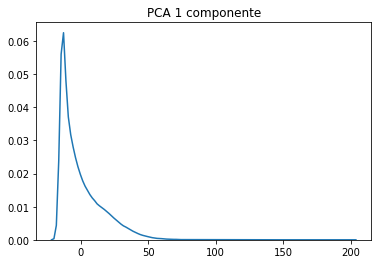

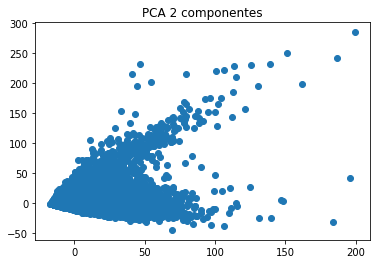

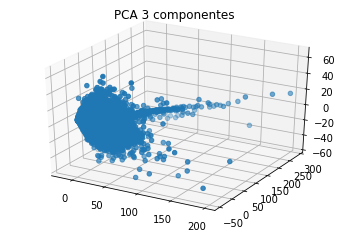

In [31]:
ver_PCA(mediana_uso_diario_apps)

varianza explicada [9.31128747e-01 3.99195907e-02 1.26918324e-02 6.96644366e-03
 3.53514301e-03 3.04678870e-03 1.24017392e-03 9.19639224e-04
 3.41730174e-04 1.10385671e-04 8.63803301e-05 1.31449680e-05]


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


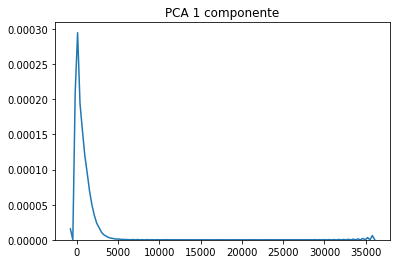

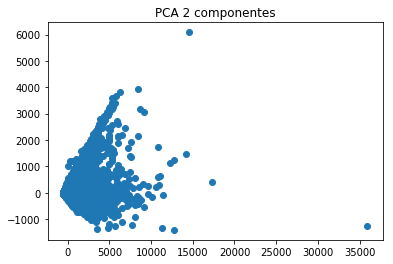

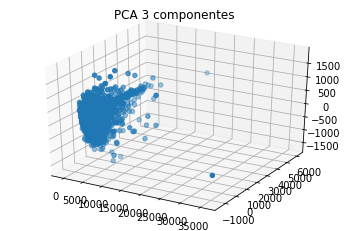

In [32]:
ver_PCA(uso_total_apps)

varianza explicada [0.64520461 0.10069911 0.0735894  0.04370359 0.03342611 0.02543744
 0.02491617 0.01892931 0.01588057 0.00920985 0.00519029 0.00381355]


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


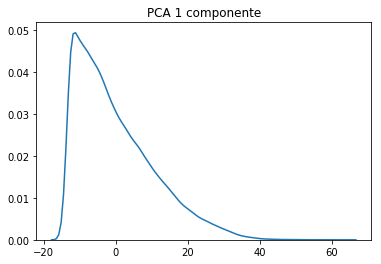

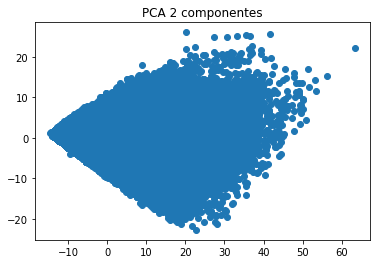

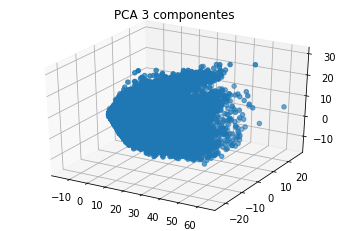

In [33]:
ver_PCA(dias_uso_apps)

varianza explicada [9.30985737e-01 3.99151445e-02 1.26902428e-02 6.96649929e-03
 3.54392298e-03 3.05235534e-03 1.24489318e-03 9.22656611e-04
 3.42230170e-04 1.13136918e-04 8.71138850e-05 7.19375950e-05
 1.42278263e-05 1.32872384e-05 6.87454345e-06 6.08115034e-06
 5.62653033e-06 5.08183417e-06 4.54388088e-06 3.72928928e-06
 2.11394921e-06 1.44762923e-06 8.61278666e-07 2.54874089e-07]


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


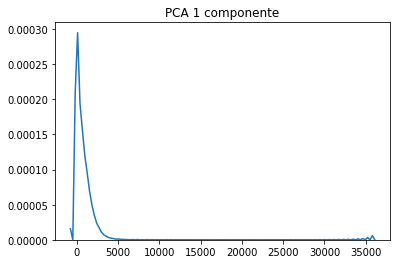

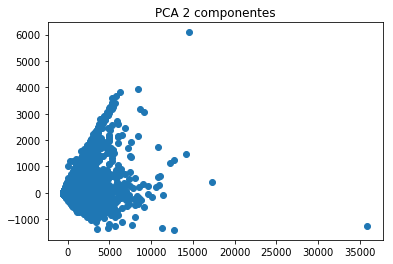

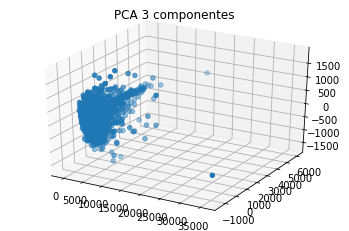

In [34]:
ver_PCA(uso_total_y_dias)

varianza explicada [9.99999593e-01 2.36515350e-07 7.08557901e-08 2.61161853e-08
 1.90420228e-08 1.58400659e-08 1.44226026e-08 9.47103659e-09
 7.75252073e-09 4.30254958e-09 1.66531132e-09 9.01441090e-10
 5.36464909e-10 3.01308456e-11]


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


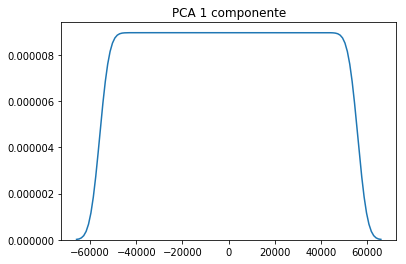

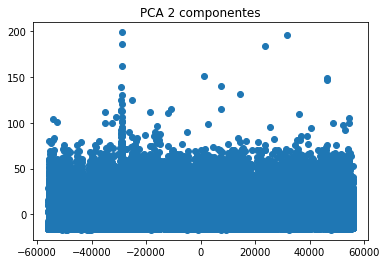

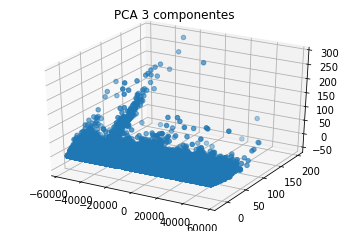

In [35]:
ver_PCA(mediana_uso_y_dias)